# Non-Parametric Statistics Workshop 2
Workshop done by:  
- David Plazas Escudero
- Juan Pablo Vidal
- Juan Sebastián Cárdenas-Rodríguez

## Packages and Global behavior

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from IPython.display import set_matplotlib_formats
from math import comb
from matplotlib import cm, colors, rc
from scipy.spatial.distance import mahalanobis as mh
from sklearn.covariance import MinCovDet
from sklearn.covariance import LedoitWolf

set_matplotlib_formats('png', 'pdf')

%matplotlib inline
rc('text', usetex=True)

folder_fig = "figs"
dir_fig = lambda x: os.path.join(folder_fig, x)
np.random.seed(43)

def set_size(w, h, ax):
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

# Aesthetic
end = '\033[0m'
bold = '\033[1m'
blue = '\033[94m'
red = '\033[91m'
header = "===================================="
n_spaces = 3

def print_results(dictionary):
    max_length = max(map(lambda x: len(x), dictionary))
    print(header)
    for key in dictionary:
        spaces_aux = n_spaces + (max_length - len(key))
        spaces = " " * spaces_aux
        print(bold + str(key) + end + spaces + str(dictionary[key]))

## Assets Analysis
Reading file and creating an array with each data.

In [35]:
# Read assets data
file = open("return.txt").readlines()
data = []
for line in file:
    row = []
    acum = ""
    for char in line:
        if char != " ":
            acum += char
        if char == " " and len(acum) != 0:
            row.append(float(acum))
            acum = ""
    if acum != "":
        row.append(float(acum))
    data.append(row)

data = np.array(data, dtype=np.float)

Use Wilcoxon RankSum Test to check which assets are not drawn from the same distribution. As seen in the matrix, the elements that are not drawn from the same distribution are:
- Assets 3 and Assets 6
- Assets 5 and Assets 6

In [63]:
sample = data[:550, :]

# Wilcoxon ranksum test
results = np.ones((sample.shape[1], sample.shape[1]))
for i in range(sample.shape[1]):
    for j in range(sample.shape[1]):
        if i == j:
            continue
        _, results[i, j] = st.ranksums(sample[:, i], sample[:, j])

# Result of test
alpha = 0.05
print((results <= alpha).astype(np.int))

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


### Probability Density Function
Here `kernel_density` estimates the density to a pair of data calculating the Kernel by using different methods.
1. `method = 0` uses the Uniform method.
2. `method = 1` uses the Triangular method.
3. `method = 2` uses the Epanechnikov method.
4. `method = 3` uses the Bi-squared method
5. `method = 4` uses the Gaussian method.

In [64]:
# method =
## 0 -> Uniform
## 1 -> Triangular
## 2 -> Epanechnikov
## 3 -> Bi-squared
## 4 -> Gaussian
def kernel_density(x, data, h, method=0):
    m = data.size
    u = (x - data) / h
    
    if h <= 0:
        h = data.std(ddof=1) * (4 / (3*m))**(1 / 5)
    ind = np.logical_and(-1 < u, u < 1).astype(np.int)
    if method == 0:
        I = 0.5 * ind
    elif method == 1:
        I = (1 - np.abs(u)) * ind
    elif method == 2:
        I = 0.75 * (1 - u ** 2) * ind
    elif method == 3:
        I = (15 / 16) * (1 - 2 * u ** 2 + u ** 4) * ind
    else:
        I = ((1 / np.sqrt(2*np.pi)) * np.exp(-0.5 * u ** 2))
    
    return 1 / (m * h) * I.sum()

# Estimate the probability density function for a given sample
def estimate_density(sample, h, method=0, xs=None):
    if xs is None:
        xs = np.sort(sample)
    density = np.zeros(xs.size)
    i = 0
    for x in xs:
        density[i] = kernel_density(x, sample, h, method=method)
        i += 1
    return xs, density

Comparison of the probability density function of two samples that pass the Wilcoxon test, i.e. that there is evidence to affirm that the samples are drawn from the same distribution.

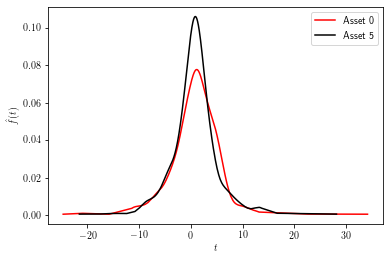

In [135]:
# Assets that pass the test
xs0, density_0 = estimate_density(sample[:, 0], -1, method=4)
xs1, density_1 = estimate_density(sample[:, 5], -1, method=4)

# Plotting
plt.plot(xs0, density_0, 'r', label="Asset 0")
plt.plot(xs1, density_1, "k", label="Asset 5")
plt.legend()
plt.ylabel("$\hat{f}(t)$")
plt.xlabel("$t$")
plt.savefig(dir_fig("kernel_assets.pdf"), bbox_inches='tight')
plt.show()

Comparison of the probability density function of two samples that do not pass the Wilcoxon test, i.e. that there is evidence to reject that the samples are drawn from the same distribution.

In [66]:
# Assets that do not pass the test
xs2, density_2 = estimate_density(sample[:, 2], -1, method=4)
xs5, density_5 = estimate_density(sample[:, 5], -1, method=4)

plt.plot(xs2, density_2, 'r', label="Asset 2")
plt.plot(xs5, density_5, "k", label="Asset 5")
plt.legend()
plt.ylabel("$\hat{f}(t)$")
plt.xlabel("$t$")
plt.savefig(dir_fig("kernel_assets_not.pdf"), bbox_inches='tight')
plt.show()

### Regression Model
Extraction of data that do not pass the Wilcoxon Rank Sum test. The assets chosen are the Asset 3 and the Asset 6.

In [67]:
# Regression model
x = data[:, 2]
y = data[:, 5]

plt.scatter(x, y, color="k", s=5)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig(dir_fig("scatter_xy.pdf"), bbox_inches='tight')
plt.show()

Functions for constructing the regression model. 

`plot_regression_model` plots a regression model, using the estimated parameters and `regression_model` finds the parameters by a **non-robust** covariance matrix and plots the data with the estimated linear model.

In [68]:
# Plot the regression model, given the estimated parameters.
def plot_regression_model(x, y, title, beta0, beta1):
    xs = np.linspace(x.min(), x.max(), 1000)
    ys = (beta0 + beta1 * xs).reshape(xs.size)
    plt.plot(xs, ys, "r")
    plt.scatter(x, y, color="k", s=5)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.savefig(dir_fig(title), bbox_inches='tight')
    plt.show()
    

# Construct the regression model and plot the data with it's linear model.
def regression_model(x, y, title):
    # Fitting model
    model = sm.OLS(y, x)
    results = model.fit()
    print(results.summary())

    # Finding parameters
    beta1 = results.params
    beta0 = y.mean() - beta1 * x.mean()

    # Plotting
    plot_regression_model(x, y, title, beta0, beta1)
    
    return results

Result and plotting of the **non-robust** linear model with the original data.

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.483
Model:                            OLS   Adj. R-squared (uncentered):              0.482
Method:                 Least Squares   F-statistic:                              1043.
Date:                Wed, 20 May 2020   Prob (F-statistic):                   3.33e-162
Time:                        11:06:56   Log-Likelihood:                         -2941.2
No. Observations:                1119   AIC:                                      5884.
Df Residuals:                    1118   BIC:                                      5889.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

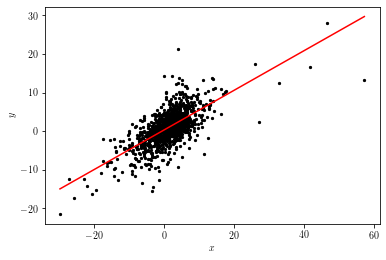

In [69]:
_ = regression_model(x, y, "scatter_vs_model.pdf")

### Outlier Removal
Functions to calculate statistical depth are presented here.
1. `depth_tukey` calculates the statistical depth using Tukey (1975) method.
2. `depth_mahal` calculates the statistical depth using the Mahalanobis (1936) distance.

Finally, `remove_outliers` removes the 15% of the points with the least statistical depth.

In [70]:
# Tukey statistical depth
def depth_tukey(point, data, n):
    r, c = data.shape
    
    u = np.random.normal(size=(c, n))
    
    # Calculate scalars
    scalar = data.dot(u)
    
    scalar2 = point.dot(u)
    
    replic = np.ones((r, 1)).dot(scalar2)
    diff = scalar - replic
    diff_indicator = (diff > 0).astype(np.int)
    
    return diff_indicator.mean(axis=0).min()


# Mahalanobis distance
def mahal(u, v, inv_matrix):
    distance = []
    
    for i in range(u.shape[0]):
        distance.append(mh(u[i, :], v, inv_matrix) ** 2)
    distance = np.array(distance)

    return distance


# Mahalanobis statistical depth
def depth_mahal(point, data):
    mean = data.mean(axis=0)
    if point.ndim == 1:
        point = point.reshape((1, data.shape[1]))
    
    inv_cov = np.linalg.inv(np.cov(data.transpose()))
    
    depth = 1 / (1 + mahal(point, mean, inv_cov))
    
    return depth

# Finding depth of each point
def remove_outliers(x, y, method=0):
    depths = []
    points = np.array([x, y]).transpose()
    for j in range(x.size):
        point = np.array([[x[j], y[j]]])
        if method == 0:
            depth = depth_tukey(point, points, 300)
        else:
            depth = depth_mahal(point, points)
        depths.append(depth)

    depths = np.array(depths)
    new_data = points.tolist()
    depths_aux = depths.copy()

    max_depth = depths.max()
    indexes = []
    for i in range(int(0.15 * len(depths))):
        min_index = depths_aux.argmin()
        indexes.append(min_index)

        depths_aux[min_index] = max_depth

    indexes = list(sorted(indexes, reverse=True))
    for i in indexes:
        new_data.pop(i)

    return np.array(new_data)

Removing outliers using **Tukey** method and plotting the new data with it's non-robust linear regression model.

In [72]:
new_data = remove_outliers(x, y)
results = regression_model(new_data[:, 0], new_data[:, 1], "scatter_vs_model_tukey.pdf")

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.442
Model:                            OLS   Adj. R-squared (uncentered):              0.441
Method:                 Least Squares   F-statistic:                              752.2
Date:                Wed, 20 May 2020   Prob (F-statistic):                   1.77e-122
Time:                        11:07:15   Log-Likelihood:                         -2195.8
No. Observations:                 952   AIC:                                      4394.
Df Residuals:                     951   BIC:                                      4398.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

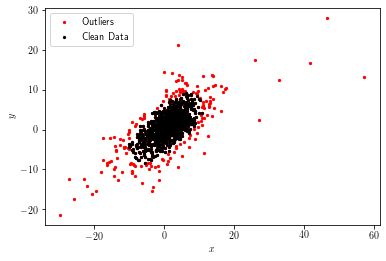

In [136]:
plt.scatter(x, y, color="r", label="Outliers", s=5)
plt.scatter(new_data[:, 0], new_data[:, 1], color="k", label="Clean Data", s=5)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.savefig(dir_fig("scatter_vs_outliers.pdf"), bbox_inches='tight')
plt.show()

Removing outliers using **Mahalanobis** distance and plotting the new data with it's non-robust linear regression model.

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.464
Model:                            OLS   Adj. R-squared (uncentered):              0.463
Method:                 Least Squares   F-statistic:                              821.8
Date:                Wed, 20 May 2020   Prob (F-statistic):                   9.18e-131
Time:                        11:07:26   Log-Likelihood:                         -2166.0
No. Observations:                 952   AIC:                                      4334.
Df Residuals:                     951   BIC:                                      4339.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

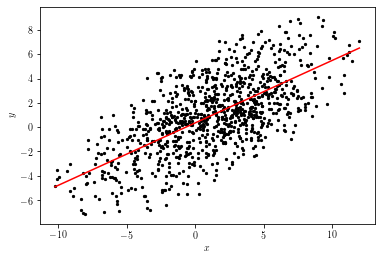

In [73]:
new_data_mahal = remove_outliers(x, y, method=1)
results = regression_model(new_data_mahal[:, 0], new_data_mahal[:, 1], "scatter_vs_model_mahal.pdf")

In [75]:
plt.scatter(x, y, color="r", label="Outliers", s=5)
plt.scatter(new_data_mahal[:, 0], new_data_mahal[:, 1], color="k", label="Clean Data", s=5)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.savefig(dir_fig("scatter_vs_outliers_mahal.pdf"), bbox_inches='tight')
plt.show()

#### Outliers with Residual
The function `remove_outliers_residuals` removes 15% of the points with maximum residuals. In each iteration a point is removed and a new non-robust linear regression model is created.

In [76]:
def remove_outliers_residuals(x, y, results):
    points = np.array([x, y]).transpose()
    residuals = np.abs(results.resid)
    data_aux = points.tolist()

    indexes = []
    for i in range(int(0.15 * len(data_aux))):
        max_index = residuals.argmax()
        data_aux.pop(max_index)

        data_aux = np.array(data_aux)
        residuals = np.abs(sm.OLS(data_aux[:, 1], data_aux[:, 0]).fit().resid)
        data_aux = data_aux.tolist()


    return np.array(data_aux)

Plotting of data by removing outliers using the previous function.

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.620
Model:                            OLS   Adj. R-squared (uncentered):              0.619
Method:                 Least Squares   F-statistic:                              1550.
Date:                Wed, 20 May 2020   Prob (F-statistic):                   6.56e-202
Time:                        11:07:34   Log-Likelihood:                         -2061.4
No. Observations:                 952   AIC:                                      4125.
Df Residuals:                     951   BIC:                                      4130.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

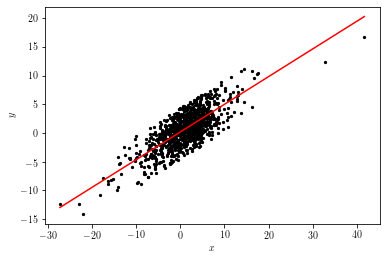

In [77]:
data_aux = remove_outliers_residuals(x, y, results)
_ = regression_model(data_aux[:, 0], data_aux[:, 1], "scatter_vs_model_resid.pdf")

### Robust Linear Regression
Here functions to calculate a robust linear regression and the significance of each parameter is presented.
1. `cov_linear_regression` is a function that estimates the parameter $\beta_1$ using a robust covariance matrix.

    1. `method = 0` uses the comedian matrix.
    
    2. `method = 1` uses the covariance matrix calculated by using the Spearman (1904) rank correlation coefficient matrix.
    
    3. `method = 2`uses the covariance matrix calculated by using the Kendall (1948) rank correlation coefficient matrix.
    
    4. `method = 3` uses the covariance matrix calculated by the Fast MCD algorithm created by Rousseeuw (1999).
    
    5. `method = 4`uses the covariance matrix calculated by the Shrinkages algorithm created by Ledoit (2012).

In [147]:
# Generic method to convert from correlation matrix to covariance matrix
def corr_to_cov(data, correlation):
    stds = data.std(axis=0, ddof=1)

    cov = np.zeros(correlation.shape)
    for i in range(correlation.shape[0]):
        for j in range(correlation.shape[1]):
            cov[i, j] = correlation[i, j] * stds[i] * stds[j]

    return cov

# Calculate comedian for two vectors
def comedian(u, v):
    median_u = np.quantile(u, 0.5)
    median_v = np.quantile(v, 0.5)
    
    aux = (u - median_u) * (v - median_v)
    
    return np.quantile(aux, 0.5)

# Calculate comedian matrix
def calculate_com(sample):
    com = np.zeros((sample.shape[1], sample.shape[1]))
    for i in range(sample.shape[1]):
        for j in range(sample.shape[1]):
            com[i, j] = comedian(sample[:, i], sample[:, j])
    
    return com

# method =
#    0 -> Spearman
#    1 -> Kendall
def calculate_cov_corr(sample, method=0):
    if method == 0:
        # Calculate Spearman
        spearman = pd.DataFrame(sample).corr(method="spearman").to_numpy()
        cov = corr_to_cov(sample, spearman)
    else:
        # Calculate Kendall
        kendall = pd.DataFrame(sample).corr(method="kendall").to_numpy()
        cov = corr_to_cov(sample, kendall)
    return cov


# Calculate covariance of MCD
def calculate_cov_MCD(sample):
    return MinCovDet().fit(sample).covariance_

# Calculate covariance of shrinkages
def calculate_cov_shrinkages(sample):
    return LedoitWolf().fit(sample).covariance_

# Calculate linear regression with different covariance matrix
#    method =
#       0 -> Comedian matrix
#       1 -> Spearman
#       2 -> Kendall
#       3 -> FastMCD
#       4 -> Shrinkages
def cov_linear_regression(x, y, method=0):
    if x.ndim == 1:
        x_aux = x.reshape((x.size, 1))
    else:
        x_aux = x
    
    method_1 = method - 1
    if method == 0:
        calculation = lambda matrix: calculate_com(matrix)
    elif method in range(1, 3):
        calculation = lambda matrix: calculate_cov_corr(matrix, method=method_1)
    elif method == 3:
        calculation = lambda matrix: calculate_cov_MCD(matrix)
    else:
        calculation = lambda matrix: calculate_cov_shrinkages(matrix)
    
    
    cov_x = calculation(x_aux)
    covs = []
    for i in range(x_aux.shape[1]):
        sample = np.array([x_aux[:,i], y]).transpose()
        
        cov_xy = calculation(sample)[1, 0]
        
        covs.append([cov_xy])
    covs = np.array(covs)
    
    beta1 = np.linalg.inv(cov_x).dot(covs)
    return beta1

# Percentile interval methods
def percentile_interval(stats, alpha, og):
    theta_alpha_inf = np.quantile(stats, (1 - alpha / 2))
    theta_alpha_sup = np.quantile(stats, alpha / 2)
    interval = (2*og - theta_alpha_inf, 2*og - theta_alpha_sup)
    
    return interval

# Bootstrap inference for significance of parameters
def bootstrap_inference(x, y, nboot, beta_og, alpha=0.05, method=0):
    def betas(sample):
        beta0 = cov_linear_regression(sample[:, 0], sample[:, 1], method=method)
        
        beta1 = sample[:, 1].mean() - beta0 * sample[:, 0].mean()
        
        return (beta0[0, 0], beta1[0, 0])
    
    samples = []
    indexes = range(x.size)
    for i in range(nboot):
        index_choice = np.random.choice(indexes, size=x.size)
        sample = np.array([x[index_choice], y[index_choice]]).transpose()
        samples.append(sample)
    
    params = np.array(list(map(lambda x: betas(x), samples)))
    interval_0 = percentile_interval(params[:, 0], alpha, beta_og[0])
    interval_1 = percentile_interval(params[:, 1], alpha, beta_og[1])
    
    if interval_0[0] <= 0 <= interval_0[1]:
        print(bold + "beta_0:" + end, red + "Is not signifcant." + end)
    else:
        print(bold + "beta_0:" + end, blue + "Is signifcant!" + end)
        
    if interval_1[0] <= 0 <= interval_1[1]:
        print(bold + "beta_1:" + end, red + "Is not signifcant" + end)
    else:
        print(bold + "beta_1:" + end, blue + "Is signifcant!" + end)

Linear regression and bootstrap inference using the **comedian** matrix.

In [79]:
# Comedian
beta1_cm = cov_linear_regression(x, y, method=0)
beta0_cm = y.mean() - beta1_cm * x.mean()
plot_regression_model(x, y, "scatter_vs_model_com.pdf", beta0_cm, beta1_cm)

In [144]:
print(header)
print(bold + "Significance of parameters using the comedian matrix:" + end)
bootstrap_inference(x, y, 1000, (beta0_cm, beta1_cm), method=0)

Significance of parameters using the comedian matrix:
beta_0: Is signifcant!
beta_1: Is signifcant!


Linear regression and bootstrap inference using the **Spearman** rank correlation coefficient matrix.

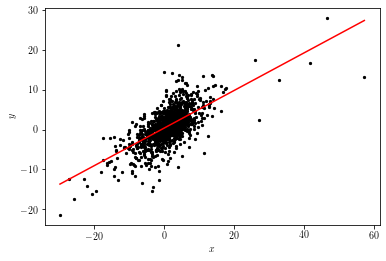

In [81]:
# Spearman
beta1_sp = cov_linear_regression(x, y, method=1)
beta0_sp = y.mean() - beta1_sp * x.mean()
plot_regression_model(x, y, "scatter_vs_model_spearman.pdf", beta0_sp, beta1_sp)

In [145]:
print(header)
print(bold + "Significance of parameters using Spearman:" + end)
bootstrap_inference(x, y, 1000, (beta0_sp, beta1_sp), method=1)

Significance of parameters using Spearman:
beta_0: Is signifcant!
beta_1: Is signifcant!


Linear regression and bootstrap inference using the **Kendall** rank correlation coefficient matrix.

In [83]:
# Kendall
beta1_k = cov_linear_regression(x, y, method=2)
beta0_k = y.mean() - beta1_k * x.mean()
plot_regression_model(x, y, "scatter_vs_model_kendall.pdf", beta0_k, beta1_k)

In [148]:
print(header)
print(bold + "Significance of parameters using Kendall:" + end)
bootstrap_inference(x, y, 1000, (beta0_k, beta1_k), method=2)

Significance of parameters using Kendall:
beta_0: Is signifcant!
beta_1: Is not signifcant


Linear regression and bootstrap inference using the **Fast MCD algorithm**.

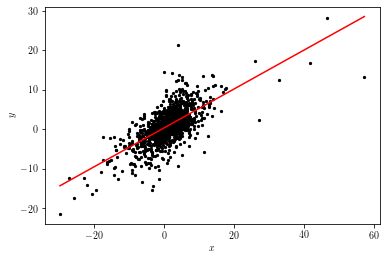

In [88]:
# Fast MCD
beta1_mcd = cov_linear_regression(x, y, method=3)
beta0_mcd = y.mean() - beta1_mcd * x.mean()
plot_regression_model(x, y, "scatter_vs_model_mcd.pdf", beta0_mcd, beta1_mcd)

In [157]:
print(header)
print(bold + "Significance of parameters using Fast MCD:" + end)
bootstrap_inference(x, y, 500, (beta0_mcd, beta1_mcd), method=3)

Significance of parameters using Fast MCD:
beta_0: Is signifcant!
beta_1: Is signifcant!


Linear regression and bootstrap inference using **Shrinkages**.

In [90]:
# Shrinkages
beta1_sh = cov_linear_regression(x, y, method=4)
beta0_sh = y.mean() - beta1_sh * x.mean()
plot_regression_model(x, y, "scatter_vs_model_shrinkages.pdf", beta0_sh, beta1_sh)

In [151]:
print(header)
print(bold + "Significance of parameters using Shrinkages:" + end)
bootstrap_inference(x, y, 1000, (beta0_sh, beta1_sh), method=4)

Significance of parameters using Shrinkages:
beta_0: Is signifcant!
beta_1: Is signifcant!


## Mixture
A mixture is created by creating two uniform random variables $x^a, x^b$ and joining then to create the following two random variables:

$$ X \sim 0.2 \mathrm{U}[6, 8] + 0.8 \mathrm{U}[2, 10] $$ and
$$ Y \sim 0.2 \mathrm{N}[-2x^a + 10, 1] + 0.8 \mathrm{U}[2x^b + 4, 1] $$

In [92]:
n_a = 3000
n_b = 10000 - n_a

# Generate vectors
x_a = np.random.uniform(low=6, high=8, size=n_a)
x_b = np.random.uniform(low=2, high=10, size=n_a)

# Select sample of each vector
x_a_choice = np.random.choice(x_a, size=int(0.2 * x_a.size), replace=False).tolist()
x_b_choice = np.random.choice(x_b, size=int(0.8 * x_b.size), replace=False).tolist()

# Generate mixture
x_a_n = list(map(lambda x: np.random.normal(loc=-2*x+10), x_a_choice))
x_b_n = list(map(lambda x: np.random.normal(loc=2*x+4), x_b_choice))

mixture_x = np.array(x_a_choice + x_b_choice)
mixture_y = np.array(x_a_n + x_b_n)

Histogram of the mixture $X$.

In [93]:
plt.hist(mixture_x, color='w', ec='black')
plt.savefig(dir_fig("histogram_mixture_x.pdf"), bbox_inches='tight')
plt.show()

Histogram of the mixture $Y$.

In [94]:
plt.hist(mixture_y, color='w', ec='black')
plt.savefig(dir_fig("histogram_mixture_y.pdf"), bbox_inches='tight')
plt.show()

Plot of $Y \text{ vs } X$

In [95]:
plt.scatter(mixture_x, mixture_y, color='k', s=5)
plt.savefig(dir_fig("scatter_mixture.pdf"), bbox_inches='tight')
plt.show()

**Non-robust** regression model for the model shown.

In [96]:
_ = regression_model(mixture_x, mixture_y, "scatter_vs_model_mixture.pdf")

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.654
Model:                            OLS   Adj. R-squared (uncentered):              0.653
Method:                 Least Squares   F-statistic:                              5657.
Date:                Wed, 20 May 2020   Prob (F-statistic):                        0.00
Time:                        11:09:10   Log-Likelihood:                         -10802.
No. Observations:                3000   AIC:                                  2.161e+04
Df Residuals:                    2999   BIC:                                  2.161e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Outlier Removal
Removing outliers using **Tukey** method and plotting the new data with it's non-robust linear regression model.

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.702
Model:                            OLS   Adj. R-squared (uncentered):              0.702
Method:                 Least Squares   F-statistic:                              6003.
Date:                Wed, 20 May 2020   Prob (F-statistic):                        0.00
Time:                        13:48:54   Log-Likelihood:                         -8985.5
No. Observations:                2550   AIC:                                  1.797e+04
Df Residuals:                    2549   BIC:                                  1.798e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

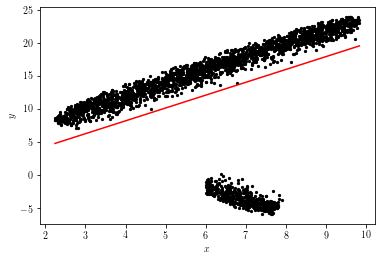

In [152]:
new_data_mixture = remove_outliers(mixture_x, mixture_y)
results_mixture = regression_model(new_data_mixture[:, 0], new_data_mixture[:, 1], 
                           "scatter_vs_model_mixture_tukey.pdf")

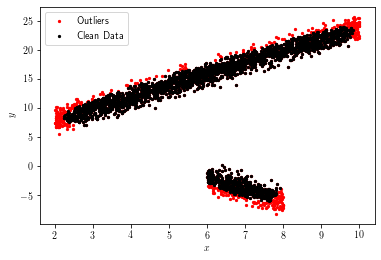

In [155]:
plt.scatter(mixture_x, mixture_y, color="r", label="Outliers", s=5)
plt.scatter(new_data_mixture[:, 0], new_data_mixture[:, 1], color="k", label="Clean Data", s=5)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.savefig(dir_fig("scatter_vs_outliers_mixture.pdf"), bbox_inches='tight')
plt.show()

Removing outliers using **Mahalanobis** distance and plotting the new data with it's non-robust linear regression model.

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.860
Model:                            OLS   Adj. R-squared (uncentered):              0.860
Method:                 Least Squares   F-statistic:                          1.565e+04
Date:                Wed, 20 May 2020   Prob (F-statistic):                        0.00
Time:                        13:48:55   Log-Likelihood:                         -8151.3
No. Observations:                2550   AIC:                                  1.630e+04
Df Residuals:                    2549   BIC:                                  1.631e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

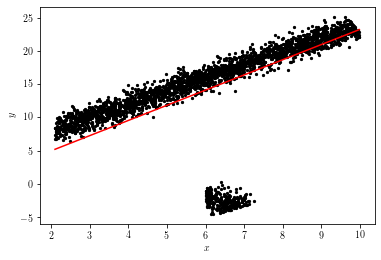

In [153]:
new_data_mixturem = remove_outliers(mixture_x, mixture_y, method=1)
results_mixturem = regression_model(new_data_mixturem[:, 0], new_data_mixturem[:, 1], 
                           "scatter_vs_model_mixture_mahal.pdf")

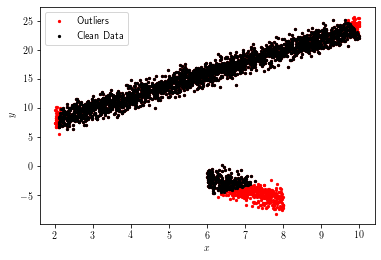

In [154]:
plt.scatter(mixture_x, mixture_y, color="r", label="Outliers", s=5)
plt.scatter(new_data_mixturem[:, 0], new_data_mixturem[:, 1], color="k", label="Clean Data", s=5)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.savefig(dir_fig("scatter_vs_outliers_mixture_mahal.pdf"), bbox_inches='tight')
plt.show()

#### Outliers with Residual
Remove outliers using the residuals of the model, as explained previously.

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.917
Model:                            OLS   Adj. R-squared (uncentered):              0.917
Method:                 Least Squares   F-statistic:                          2.821e+04
Date:                Wed, 20 May 2020   Prob (F-statistic):                        0.00
Time:                        11:10:15   Log-Likelihood:                         -7546.1
No. Observations:                2550   AIC:                                  1.509e+04
Df Residuals:                    2549   BIC:                                  1.510e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

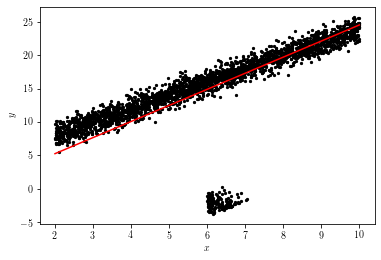

In [99]:
data_resid = remove_outliers_residuals(mixture_x, mixture_y, results)
_ = regression_model(data_resid[:, 0], data_resid[:, 1], "scatter_vs_model_resid_mix .pdf")

Linear regression and bootstrap inference using the **comedian** matrix.

In [100]:
# Comedian
beta1_cm_mix = cov_linear_regression(mixture_x, mixture_y, method=0)
beta0_cm_mix = mixture_y.mean() - beta1_cm_mix * mixture_x.mean()
plot_regression_model(mixture_x, mixture_y, "scatter_vs_model_com_mix.pdf", 
                      beta0_cm_mix, beta1_cm_mix)

In [156]:
print(header)
print(bold + "Significance of parameters using the comedian matrix:" + end)
bootstrap_inference(mixture_x, mixture_y, 1000, (beta0_cm_mix, beta1_cm_mix), method=0)

Significance of parameters using the comedian matrix:
beta_0: Is not signifcant.
beta_1: Is signifcant!


Linear regression and bootstrap inference using the **Spearman** rank correlation coefficient matrix.

In [102]:
# Spearman
beta1_sp_mix = cov_linear_regression(mixture_x, mixture_y, method=1)
beta0_sp_mix = mixture_y.mean() - beta1_sp_mix * mixture_x.mean()
plot_regression_model(mixture_x, mixture_y, "scatter_vs_model_sp_mix.pdf", beta0_sp_mix, beta1_sp_mix)

In [158]:
print(header)
print(bold + "Significance of parameters using Spearman:" + end)
bootstrap_inference(mixture_x, mixture_y, 1000, (beta0_sp_mix, beta1_sp_mix), method=1)

Significance of parameters using Spearman:
beta_0: Is signifcant!
beta_1: Is signifcant!


Linear regression and bootstrap inference using the **Kendall** rank correlation coefficient matrix.

In [104]:
# Kendall
beta1_k_mix = cov_linear_regression(mixture_x, mixture_y, method=2)
beta0_k_mix = mixture_y.mean() - beta1_k_mix * mixture_x.mean()
plot_regression_model(mixture_x, mixture_y, "scatter_vs_model_k_mix.pdf", beta0_k_mix, beta1_k_mix)

In [159]:
print(header)
print(bold + "Significance of parameters using Kendall:" + end)
bootstrap_inference(mixture_x, mixture_y, 1000, (beta0_k_mix, beta1_k_mix), method=1)

Significance of parameters using Kendall:
beta_0: Is signifcant!
beta_1: Is signifcant!


Linear regression and bootstrap inference using the **Fast MCD** algorithm.

In [106]:
# MCD
beta1_mcd_mix = cov_linear_regression(mixture_x, mixture_y, method=3)
beta0_mcd_mix = mixture_y.mean() - beta1_mcd_mix * mixture_x.mean()
plot_regression_model(mixture_x, mixture_y, "scatter_vs_model_mcd_mix.pdf", beta0_mcd_mix, 
                      beta1_mcd_mix)

In [160]:
print(header)
print(bold + "Significance of parameters using Fast MCD:" + end)
bootstrap_inference(mixture_x, mixture_y, 500, (beta0_mcd_mix, beta1_mcd_mix), method=3)

Significance of parameters using Fast MCD:
beta_0: Is signifcant!
beta_1: Is signifcant!


Linear regression and bootstrap inference using the **Shrinkages**.

In [107]:
# Shrinkages
beta1_sh_mix = cov_linear_regression(mixture_x, mixture_y, method=4)
beta0_sh_mix = mixture_y.mean() - beta1_sh_mix * mixture_x.mean()
plot_regression_model(mixture_x, mixture_y, "scatter_vs_model_sh_mix.pdf", beta0_sh_mix, beta1_sh_mix)

In [161]:
print(header)
print(bold + "Significance of parameters using Shrinkages:" + end)
bootstrap_inference(mixture_x, mixture_y, 1000, (beta0_sh_mix, beta1_sh_mix), method=1)

Significance of parameters using Shrinkages:
beta_0: Is signifcant!
beta_1: Is signifcant!


Estimating the probability density function using kernels

In [109]:
xs_mix, density_mix_x = estimate_density(mixture_x, 0.5, method=2)

plt.hist(mixture_x, ec='black', color='white', density=True)
plt.plot(xs_mix, density_mix_x, 'r')
plt.ylabel("$\hat{f}(t)$")
plt.xlabel("$t$")
plt.savefig(dir_fig("kernel_density_mixture.pdf"), bbox_inches='tight')
plt.show()

In [110]:
ys_mix, density_mix_y = estimate_density(mixture_y, 1.5, method=4)

plt.hist(mixture_y, ec='black', color='white', density=True)
plt.plot(ys_mix, density_mix_y, 'r')
plt.ylabel("$\hat{f}(t)$")
plt.xlabel("$t$")
plt.savefig(dir_fig("kernel_density_mixture_y.pdf"), bbox_inches='tight')
plt.show()

## Correlated Data
Selecting two distinct assets with the biggest correlation. This correlation was calculated by using a non-robust method.

In [111]:
cor_mat = pd.DataFrame(data).corr().to_numpy()

for i in range(cor_mat.shape[0]):
    cor_mat[i, i] = 0

max_flat = cor_mat.argmax()
index_max = (int(max_flat / data.shape[1]), max_flat - int(max_flat / data.shape[1]) * data.shape[1])

x_2 = data[:, min(index_max)]
y_2 = data[:, max(index_max)]

aux_xy = np.array([x_2, y_2]).transpose().tolist()
aux_xy = sorted(aux_xy, key=lambda t: t[0])
aux_xy = np.array(aux_xy)

x_2 = aux_xy[:, 0]
y_2 = aux_xy[:, 1]

### Nadaraya watson
Here `kernel_nw_regression`calculates a regression to a pair of data calculating the Kernel by using different methods.

1. `method = 0` uses the Uniform method.

2. `method = 1` uses the Triangular method.

3. `method = 2` uses the Epanechnikov method.

4. `method = 3` uses the Bi-squared method.

5. `method = 4` uses the Gaussian method.

In [112]:
# method =
#   0 -> Uniform
#   1 -> Triangular
#   2 -> Epanechnikov
#   3 -> Bi-squared
#   4 -> Gaussian
def kernel_nw_regression(xs, ys, h, method=0):
   
    if h <= 0:
        h = xs.std(ddof=1) * (4 / (3*xs.size))**(1 / 5)
        
    est = np.zeros(xs.size)
    for j in range(xs.size):
        u = (xs[j] - xs) / h
        
        ind = np.logical_and(-1 < u, u < 1).astype(np.int)
        if method == 0:
            I = 0.5 * ind
        elif method == 1:
            I = (1 - np.abs(u)) * ind
        elif method == 2:
            I = 0.75 * (1 - u ** 2) * ind
        elif method == 3:
            I = (15 / 16) * (1 - 2 * u ** 2 + u ** 4) * ind
        else:
            I = ((1 / np.sqrt(2*np.pi)) * np.exp(-0.5 * u ** 2))

        denom = I.sum()
        num = I.dot(ys)
        est[j] = num / denom

    return est

Estimating a regression for $y ^ 2$

In [113]:
estimation = kernel_nw_regression(x_2, y_2 ** 2, 5, method=2)

plt.scatter(x_2, y_2 ** 2, color='k', label='Data', s=5)
plt.plot(x_2, estimation, 'r', label="Estimation")
plt.xlabel("$x$")
plt.ylabel("$y^2$")
plt.legend()
plt.savefig(dir_fig("nw_cuadratic.pdf"), bbox_inches='tight')
plt.show()

Estimating a regression for $y ^3$

In [118]:
estimation = kernel_nw_regression(x_2, y_2 ** 3, 5, method=2)

plt.scatter(x_2, y_2 ** 3, color='k', label='Data', s=5)
plt.plot(x_2, estimation, 'r', label="Estimation")
plt.xlabel("$x$")
plt.ylabel("$y^3$")
plt.legend()
plt.savefig(dir_fig("nw_cubic.pdf"), bbox_inches='tight')
plt.show()

Estimating a regression for $\sqrt[3]{y}$

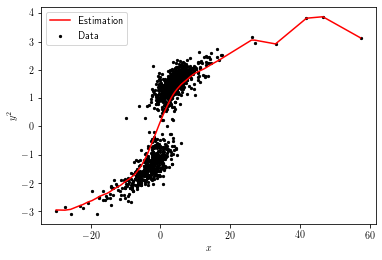

In [119]:
estimation = kernel_nw_regression(x_2, np.cbrt(y_2), 5, method=2)

plt.scatter(x_2, np.cbrt(y_2), color='k', label='Data', s=5)
plt.plot(x_2, estimation, 'r', label="Estimation")
plt.xlabel("$x$")
plt.ylabel("$y^2$")
plt.legend()
plt.savefig(dir_fig("nw_cubic_root.pdf"), bbox_inches='tight')
plt.show()

Estimating a regression for $\sin(y)$

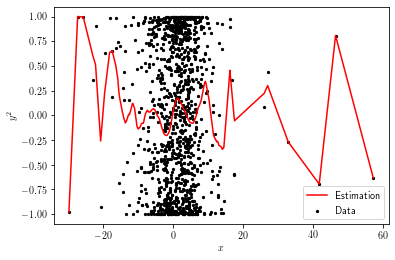

In [120]:
estimation = kernel_nw_regression(x_2, np.sin(y_2), -1, method=2)

plt.scatter(x_2, np.sin(y_2), color='k', label='Data', s=5)
plt.plot(x_2, estimation, 'r', label="Estimation")
plt.xlabel("$x$")
plt.ylabel("$y^2$")
plt.legend()
plt.savefig(dir_fig("nw_cuadratic.pdf"), bbox_inches='tight')
plt.show()

## Time of Life Data
Here the data from the file _life.txt_ is read and saved in an array.

In [121]:
# Read life data
file = open("life.txt").readlines()
data_life = []
for line in file:
    row = []
    acum = ""
    for char in line:
        if char != " ":
            acum += char
        if char == " " and len(acum) != 0:
            row.append(float(acum))
            acum = ""
    if acum != "":
        row.append(float(acum))
    data_life.append(row)

data_life = np.array(data_life, dtype=np.float)

Separate the data by a selected value `sep`.

In [122]:
# Separation of data
data0 = data_life[:, :5]

sep = 230

data1 = data0[:sep, :]
data2 = data0[sep:, :]

### D-D plot

In [123]:
# D-D Plot
def ddplot(sample0, sample1, filename=None, method=0):
    others = []
    
    sample = np.array(sample0.tolist() + sample1.tolist())
    z_0 = np.zeros(sample.shape[0])
    z_1 = np.zeros(sample.shape[0])
    
    for i in range(sample.shape[0]):
        point = sample[i, :].reshape((1, sample.shape[1]))
        if method == 0:
            z_0[i] = depth_tukey(point, sample0, 300)
            z_1[i] = depth_tukey(point, sample1, 300)
        else:
            z_0[i] = depth_mahal(point, sample0)
            z_1[i] = depth_mahal(point, sample1)
    
        
    plt.scatter(z_0, z_1, s=5, color='k')
    
    if filename is not None:
        plt.savefig(dir_fig(filename), bbox_inches='tight')
    plt.show()
    
    return z_0, z_1

D-D plot of the data using Tukey statistical depth and linear regression model.

In [124]:
z_0l, z_1l = ddplot(data1, data2, filename="ddplot_life.pdf")

In [164]:
results_life = regression_model(z_0l, z_1l, "scatter_vs_model_ddplot.pdf")

beta1_life = results_life.params
beta0_life = z_1l.mean() - beta1_life * z_0l.mean()

r0 = {"beta0": beta0_life, "beta1": beta1_life}
print_results(r0)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.888
Model:                            OLS   Adj. R-squared (uncentered):              0.887
Method:                 Least Squares   F-statistic:                              3945.
Date:                Wed, 20 May 2020   Prob (F-statistic):                   4.39e-239
Time:                        14:26:22   Log-Likelihood:                          1204.2
No. Observations:                 500   AIC:                                     -2406.
Df Residuals:                     499   BIC:                                     -2402.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

beta0   [0.00370205]
beta1   [0.9343533]


D-D plot of the data using Mahalanobis distance and linear regression model.

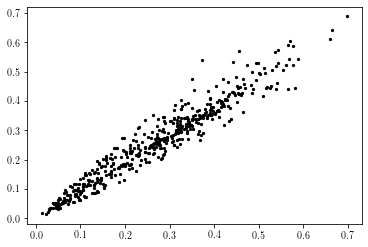

In [126]:
z_0lm, z_1lm = ddplot(data1, data2, filename="ddplot_life_mahal.pdf", method=1)

In [165]:
results_lifem = regression_model(z_0lm, z_1lm, "scatter_vs_model_ddplot_mahal.pdf")

beta1_lifem = results_lifem.params
beta0_lifem = z_1l.mean() - beta1_lifem * z_0l.mean()

r0m = {"beta0": beta0_lifem, "beta1": beta1_lifem}
print_results(r0m)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                          3.366e+04
Date:                Wed, 20 May 2020   Prob (F-statistic):                        0.00
Time:                        14:27:12   Log-Likelihood:                          960.30
No. Observations:                 500   AIC:                                     -1919.
Df Residuals:                     499   BIC:                                     -1914.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

beta0   [0.00255151]
beta1   [0.96028155]


### Asset Data
Separate the asset data by a fixed index `sep`.

In [128]:
# Separation of data
data0r = data[:, :5]

sep = 500

data1r = data0r[:sep, :]
data2r = data0r[sep:, :]

In [129]:
z_0r, z_1r = ddplot(data1r, data2r, filename="ddplot_returns.pdf")

D-D plot of the data using Tukey statistical depth and linear regression model.

In [166]:
results_r = regression_model(z_0r, z_1r, "scatter_vs_model_ddplot_returns.pdf")

beta1_r = results_r.params
beta0_r = z_1r.mean() - beta1_r * z_0r.mean()

r0r = {"beta0": beta0_r, "beta1": beta1_r}
print_results(r0r)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.944
Model:                            OLS   Adj. R-squared (uncentered):              0.944
Method:                 Least Squares   F-statistic:                          1.890e+04
Date:                Wed, 20 May 2020   Prob (F-statistic):                        0.00
Time:                        14:29:22   Log-Likelihood:                          2609.7
No. Observations:                1119   AIC:                                     -5217.
Df Residuals:                    1118   BIC:                                     -5212.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

beta0   [0.00299707]
beta1   [1.04920379]


D-D plot of the data using Mahalanobis distance and linear regression model.

In [131]:
z_0rm, z_1rm = ddplot(data1r, data2r, filename="ddplot_returns_mahal.pdf", method=1)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                          2.641e+04
Date:                Wed, 20 May 2020   Prob (F-statistic):                        0.00
Time:                        14:29:50   Log-Likelihood:                          1456.4
No. Observations:                1119   AIC:                                     -2911.
Df Residuals:                    1118   BIC:                                     -2906.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

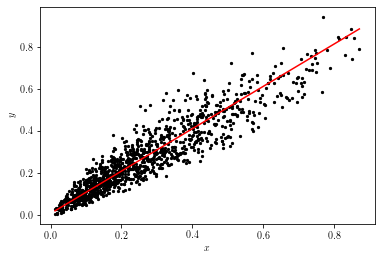

beta0   [0.00960859]
beta1   [1.00373552]


In [167]:
results_rm = regression_model(z_0rm, z_1rm, "scatter_vs_model_ddplot_returns_mahal.pdf")

beta1_rm = results_rm.params
beta0_rm = z_1rm.mean() - beta1_rm * z_0rm.mean()

r0rm = {"beta0": beta0_rm, "beta1": beta1_rm}
print_results(r0rm)

## Last Exercise

The task of identifying if two sets of images come from the same population can be addressed by comparing the grayscale of the images with a Kolmogorov-Smirnov test to test if the two images have the same grayscale distribution.

Clearly, if two images are the same, up to a small noise, they have close grayscale distributions. Thus, grayscale distribution analysis is helpful when images of the same content are compared.

Therefore, a matrix can be constructed where each row is a grayscale image and each image are cropped to the same size. Then, based on the null hypothesis that 2 sample of images are identical, a Kolmogorov-Smirnov test is performed to try to reject the hypothesis. 

It is important to know that images are subject to random noise, so there could be minor differences in the grayscale distributions (meaning that the 2 images are not identical), therefore, this test will only give us the information to reject the null hypothesis. To prove that the 2 image samples come from the same population its necessary to define “what is consider equivalent” in the context of the grayscale, thus it is necessary to build a equivalence region that include the random noise which is generated by comparing the grayscale.

# References
Kendall, M; Gibbons, J.D., 1948. _Reprinted In: Rank Correlation Methods, 1999_. Charles Griffin Book Series, ed. 5., Oxford, Oxford University Press.

Ledoit, O.; Wolf, M, 2012. _Nonlinear Shrinkage Estimation of Large-Dimensional Covariance Matrices_. In: Ann. Statist. vol. 40, pp. 1024-1060

Mahalanobis, P.C., 1936. _On the Generalised Distance in Statistics_. In: Proceedings of the National Institute of Science of India, vol. 12., Calculta, pp. 49–55

Rousseeuw, P.J.; Driessen, K.V., 1999. _A Fast Algorithm for the Minimum Covariance Determinant Estimator_. In: Technometrics, pp. 212-223

Spearman, C. 1904. _The Proof and Measurement of Association Between Two Things_. In: American Journal of Psychology, vol. 15., pp. 72–101.

Tukey, J.W., 1975. _Mathematics and Picturing of Data_. In: Proceedings of ICM, vol. 2. Vancouver, pp. 523–531